# WOA Data
To compare with SOSE, SODA and ECCOv4r3 products

In [1]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [2]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.447ce3e12d994d58b3a30fbae4228f24/status,


In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
import xarray as xr
import gsw
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [4]:
#WG boundaries (65˚W, 30˚E; 80˚S, 52˚S)
lower_lat = -79.5
upper_lat = -52.5
left_lon = -64.5
right_lon = 30.5

In [5]:
#set the boundaries
lat_range = dict(lat=slice(lower_lat, upper_lat))
lon_range = dict(lon=slice(left_lon, right_lon))

# testing to load in all nc files
- file naming convention is in [this pdf](https://www.ncei.noaa.gov/thredds-ocean/catalog/ncei/archive/data/0114815/DOC/catalog.html) on page 9.

# <span style='color:Orange'> 2005 - 2012 period

In [6]:
url = 'https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/archive/data/0114815/public/temperature/netcdf/A5B2/1.00/woa13_A5B2_t00_01.nc'
surl = 'https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/archive/data/0114815/public/salinity/netcdf/A5B2/1.00/woa13_A5B2_s00_01.nc'
ds_salt = xr.open_dataset(url, decode_times=False)
ds_temp = xr.open_dataset(surl, decode_times=False)
ds = xr.merge([ds_salt, ds_temp])
ds

<xarray.Dataset>
Dimensions:             (lat: 180, nbounds: 2, lon: 360, depth: 102, time: 1)
Coordinates:
  * lat                 (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon                 (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * depth               (depth) float32 0.0 5.0 10.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time                (time) float32 6.0
Dimensions without coordinates: nbounds
Data variables: (12/19)
    crs                 int32 -2147483647
    lat_bnds            (lat, nbounds) float32 -90.0 -89.0 -89.0 ... 89.0 90.0
    lon_bnds            (lon, nbounds) float32 -180.0 -179.0 ... 179.0 180.0
    depth_bnds          (depth, nbounds) float32 0.0 2.5 ... 5.45e+03 5.5e+03
    climatology_bounds  (time, nbounds) float32 0.0 12.0
    t_an                (time, depth, lat, lon) float32 ...
    ...                  ...
    s_mn                (time, depth, lat, lon) float32 ...
    s_dd                (time, depth, lat, lon) float64 ...
    s_sd                (time, depth, lat, lon) float32 ...
    s_se                (time, depth, lat, lon) float32 ...
    s_oa                (time, depth, lat, lon) float32 ...
    s_gp                (time, depth, lat, lon) float64 ...
Attributes: (12/44)
    Conventions:                   CF-1.6
    title:                         World Ocean Atlas 2013 version 2 : sea_wat...
    summary:                       Climatological mean temperature for the gl...
    references:                    Locarnini, R. A., A. V. Mishonov, J. I. An...
    institution:                   National Oceanographic Data Center(NODC)
    comment:                       global climatology as part of the World Oc...
    ...                            ...
    nodc_template_version:         NODC_NetCDF_Grid_Template_v1.0
    license:                       These data are openly available to the pub...
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    metadata_link:                 http://www.nodc.noaa.gov/OC5/WOA13/pr_woa1...
    date_created:                  2011-09-28 
    date_modified:                 2011-09-28

## <span style='color:Brown'> Converting __in situ__ temperature to __potential__ temperature

In [7]:
tan = ds.t_an.load()

In [8]:
#change levels to pressure
pressure = xr.apply_ufunc(gsw.p_from_z, tan.depth, ds.lat, 
                          output_dtypes=[float, ],
                          dask='parallelized').reset_coords(drop=True).load()
pressure.name = 'pressure'

In [9]:
#change practical salinity [psu] to absolute salinity [g/kg]
sa = xr.apply_ufunc(gsw.SA_from_SP, ds.s_an, pressure, ds.lon, ds.lat,
                    output_dtypes=[ds.s_an.dtype],
                    dask='parallelized').reset_coords(drop=True)
sa.name = 'SA'

In [10]:
pt = xr.apply_ufunc(gsw.pt0_from_t, sa, tan, pressure,
                    output_dtypes=[tan.dtype],
                    dask='parallelized').reset_coords(drop=True)
pt.name = 'PT'

## <span style='color:Brown'> Bottom Potential Temperatures

In [11]:
# this gives us the depth of the bottom cell
lev_max = pt.depth.where(pt.notnull()).max(dim='depth')
# which we can use as an indexer
pt_bottom = pt.sel(depth=lev_max.fillna(0.))

In [12]:
pt_bottom_wg = pt_bottom.sel(**lat_range, **lon_range)

In [13]:
surface_mask_pt = (pt_bottom_wg.notnull()).load()

In [14]:
pt_bottom_wg.to_netcdf('pt_bottom_wg_0512.nc')

In [15]:
url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/topography/ETOPO1/etopo1_bed'
bath = xr.open_dataset(url, decode_times=False)

In [16]:
bath.b_bathy[0]

<xarray.DataArray 'b_bathy' (lat: 10801, lon: 21601)>
[233312401 values with dtype=float32]
Coordinates:
    time     float64 -366.0
  * lat      (lat) float64 -90.0 -89.98 -89.97 -89.95 ... 89.95 89.97 89.98 90.0
  * lon      (lon) float64 -180.0 -180.0 -180.0 -179.9 ... 180.0 180.0 180.0
Attributes:
    long_name:  etopo1 bedrock global relief model-topography/bathymetry (m)

In [17]:
bath_wg = bath.b_bathy[0].sel(**lat_range, **lon_range)
bath_wg_woa = bath_wg.interp({'lat':pt_bottom_wg.lat, 'lon':pt_bottom_wg.lon})

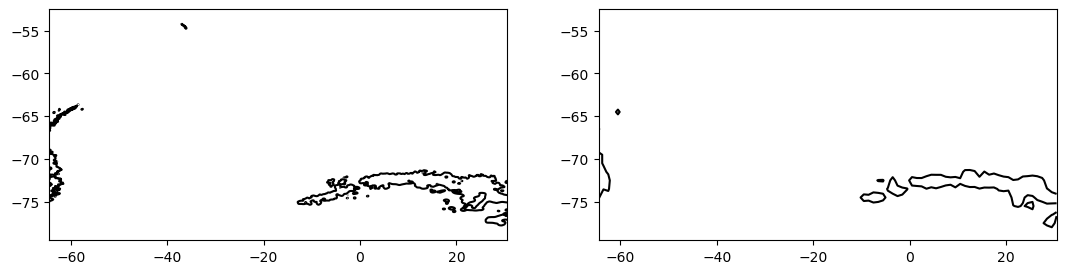

In [18]:
#compare orig bath resolution vs interpolated onto woa's resolution 
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(13,3))
ax0.contour(bath_wg.lon, bath_wg.lat, bath_wg, levels=[1000], colors='k')
ax1.contour(bath_wg_woa.lon, bath_wg_woa.lat, bath_wg_woa, levels=[1000], colors='k')

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, 'Bottom temperature from 1˚ WOA data\n averaged over 2005-2012')

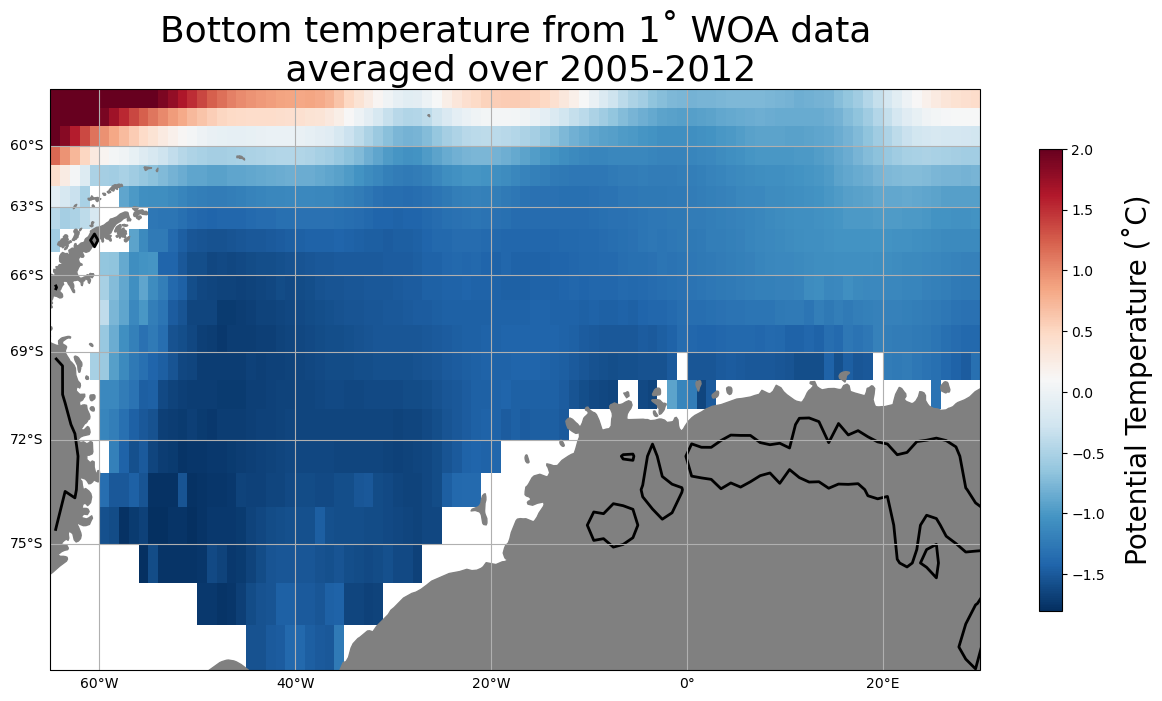

In [20]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -57], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

#1000m isobath
ax.contour(bath_wg_woa.lon, bath_wg_woa.lat, bath_wg_woa, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(pt_bottom_wg.lon, pt_bottom_wg.lat, pt_bottom_wg[0], transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature (˚C)", labelpad=12, fontsize=20)

#ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

plt.title('Bottom temperature from 1˚ WOA data\n averaged over 2005-2012', fontsize=26)
#plt.savefig('bot-temp-woa0512-1kmisobath.pdf');

## <span style='color:Red'> Bottom Temperature Error (start)

In [21]:
pt_error = xr.apply_ufunc(gsw.pt0_from_t, sa, ds.t_se, pressure,
                    output_dtypes=[ds.t_se.dtype],
                    dask='parallelized').reset_coords(drop=True)
pt_error.name = 'PT_error'

## <span style='color:Brown'> Bottom Potential Temperature Error

In [22]:
# this gives us the depth of the bottom cell
lev_max_error = pt_error.depth.where(pt_error.notnull()).max(dim='depth')
# which we can use as an indexer
pt_bottom_error = pt_error.sel(depth=lev_max_error.fillna(0.))

In [23]:
pt_bottom_wg_error = pt_bottom_error.sel(**lat_range, **lon_range)

In [24]:
surface_mask_pt_error = (pt_bottom_wg_error.notnull()).load()

In [164]:
pt_bottom_wg_error.to_netcdf('pt_bottom_error_0512.nc', mode='w')

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, 'Standard error of bottom temperature \nfrom 1˚ WOA data averaged over 2005-2012')

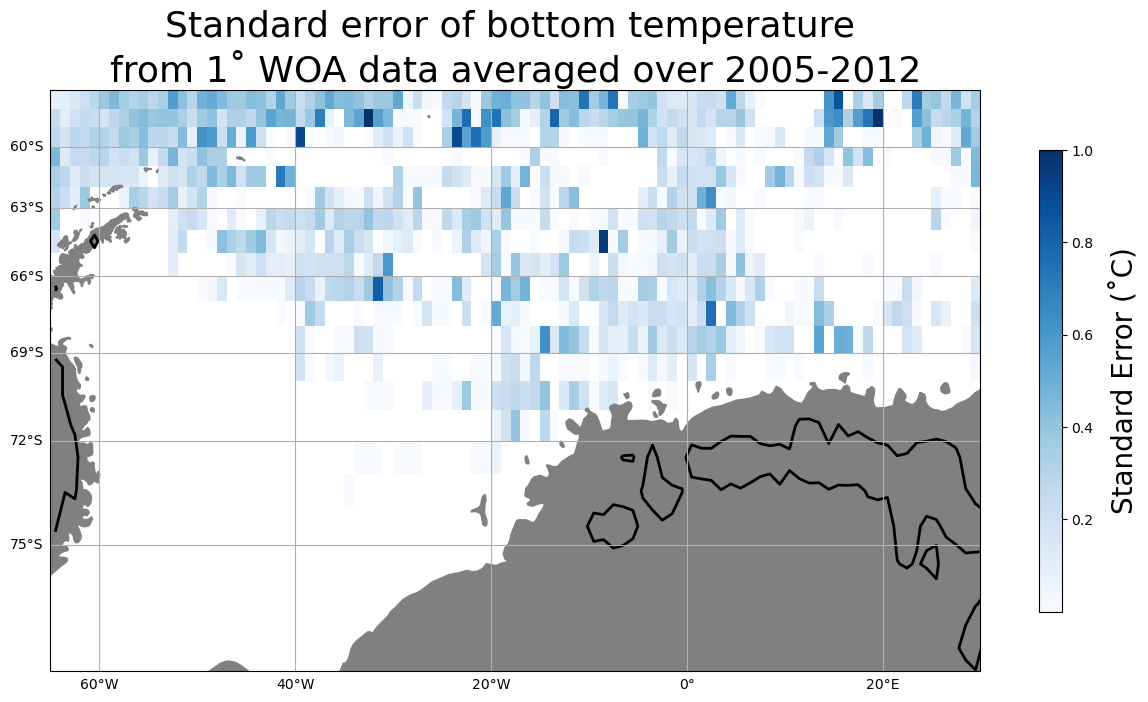

In [25]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -57], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
#1000m isobath
ax.contour(bath_wg_woa.lon, bath_wg_woa.lat, bath_wg_woa, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(pt_bottom_wg_error.lon, pt_bottom_wg_error.lat, pt_bottom_wg_error[0], transform=ccrs.PlateCarree(), cmap='Blues', vmax=1)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Standard Error (˚C)", labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

plt.title('Standard error of bottom temperature \nfrom 1˚ WOA data averaged over 2005-2012', fontsize=26)
#plt.savefig('ste-bot-temp-woa0512-1kmisobath.pdf');

## <span style='color:Red'> Bottom Temperature Error (end)

## <span style='color:Brown'> Bottom Practical Salinities

In [167]:
# this gives us the depth of the bottom cell
lev_max_slt = ds.s_an.depth.where(ds.s_an.notnull()).max(dim='depth')
# which we can use as an indexer
san_bottom = ds.s_an.sel(depth=lev_max_slt.fillna(0.))

In [168]:
san_bottom_wg = san_bottom.sel(**lat_range, **lon_range)

In [169]:
surface_mask_san = (san_bottom_wg.notnull()).load()

In [171]:
san_bottom_wg.to_netcdf('san_bottom_wg_0512.nc')

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


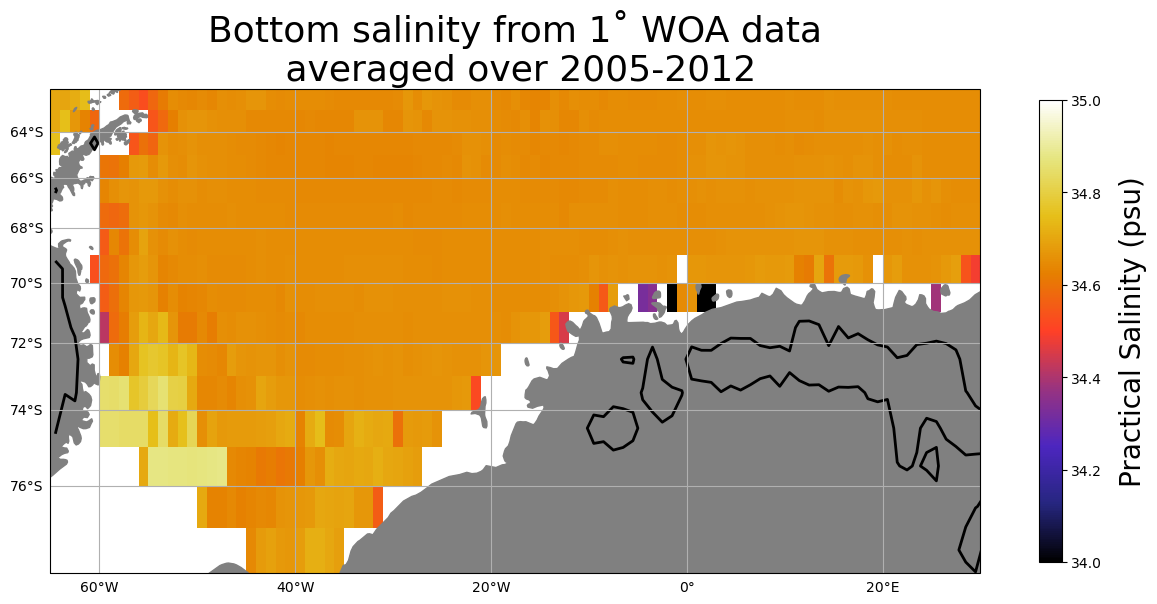

In [172]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))
#1000m isobath
ax.contour(bath_wg_woa.lon, bath_wg_woa.lat, bath_wg_woa, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(san_bottom_wg.lon, san_bottom_wg.lat, san_bottom_wg[0], cmap='CMRmap', vmin=34, vmax=35, transform=ccrs.PlateCarree())

cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label('Practical Salinity (psu)', labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

plt.title('Bottom salinity from 1˚ WOA data\n averaged over 2005-2012', fontsize=26 )
plt.savefig('bot-salt-woa0512-1kmisobath.pdf');

## <span style='color:Red'> Bottom Salinity Error (start)

In [173]:
# this gives us the depth of the bottom cell
lev_max_slt_error = ds.s_se.depth.where(ds.s_se.notnull()).max(dim='depth')
# which we can use as an indexer
san_bottom_error = ds.s_se.sel(depth=lev_max_slt_error.fillna(0.))

In [174]:
san_bottom_wg_error = san_bottom_error.sel(**lat_range, **lon_range)

In [175]:
san_bottom_wg_error.to_netcdf('san_bottom_error_0512.nc', mode='w')

In [176]:
surface_mask_san_error = (san_bottom_wg_error.notnull()).load()

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


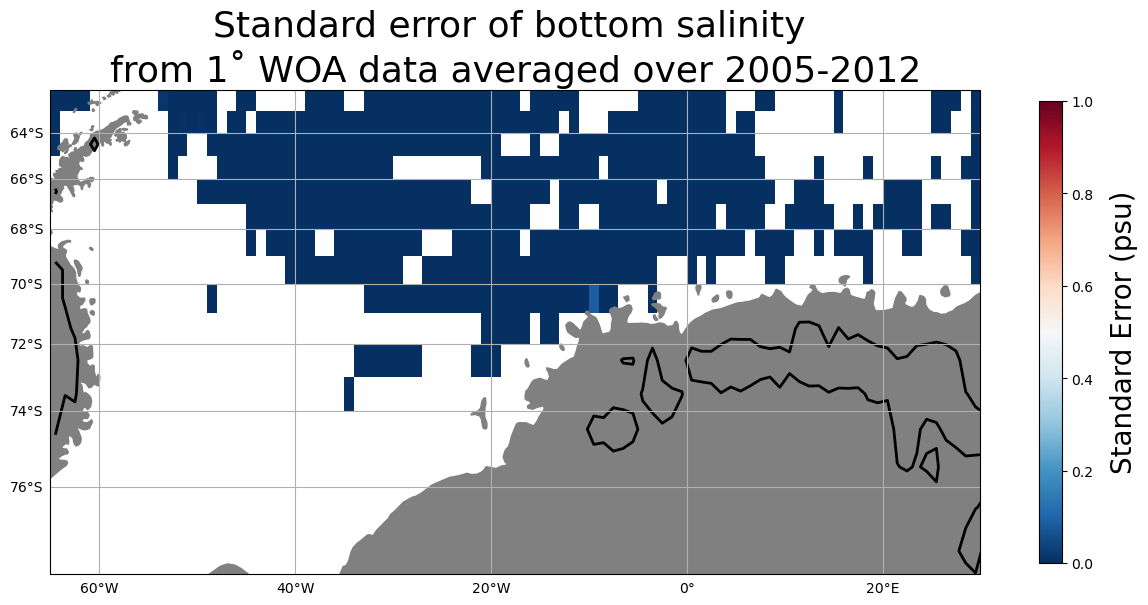

In [177]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))
#1000m isobath
ax.contour(bath_wg_woa.lon, bath_wg_woa.lat, bath_wg_woa, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(san_bottom_wg_error.lon, 
                   san_bottom_wg_error.lat, 
                   san_bottom_wg_error[0], cmap='RdBu_r', transform=ccrs.PlateCarree(), vmax=1)

cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label('Standard Error (psu)', labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

plt.title('Standard error of bottom salinity \nfrom 1˚ WOA data averaged over 2005-2012', fontsize=26 )
plt.savefig('ste-bot-salt-woa0512-1kmisobath.pdf');

## <span style='color:Red'> Bottom Salinity Error (end)

# <span style='color:Orange'> 1981 - 2010 period

In [2]:
ds_salt = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA18/1_deg/annual/Avg_Decades_1981-2010/salt')
ds_temp = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA18/1_deg/annual/Avg_Decades_1981-2010/temp')
ds = xr.merge([ds_salt, ds_temp])
ds

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:150: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:202: CFWarning: this date/calendar/year zero convention is not supported by CF
  cftime.num2date(num_dates, units, calendar, only_use_cftime_datetimes=True)
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use

<xarray.Dataset>
Dimensions:  (time: 1, lev: 102, lat: 180, lon: 360)
Coordinates:
  * time     (time) object -0001-01-15 00:00:00
  * lev      (lev) float64 0.0 5.0 10.0 15.0 ... 5.2e+03 5.3e+03 5.4e+03 5.5e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables: (12/14)
    san      (time, lev, lat, lon) float32 ...
    smn      (time, lev, lat, lon) float32 ...
    sdd      (time, lev, lat, lon) float32 ...
    ssd      (time, lev, lat, lon) float32 ...
    sse      (time, lev, lat, lon) float32 ...
    soa      (time, lev, lat, lon) float32 ...
    ...       ...
    tmn      (time, lev, lat, lon) float32 ...
    tdd      (time, lev, lat, lon) float32 ...
    tsd      (time, lev, lat, lon) float32 ...
    tse      (time, lev, lat, lon) float32 ...
    toa      (time, lev, lat, lon) float32 ...
    tgp      (time, lev, lat, lon) float32 ...
Attributes:
    title:          World Ocean Atlas 2018: sea water salinity Annual 1981-20...
    Conventions:    COARDS\nGrADS
    dataType:       Grid
    documentation:  http://apdrc.soest.hawaii.edu/datadoc/woa18.php
    history:        Mon Jun 13 10:45:42 HST 2022 : imported by GrADS Data Ser...

## <span style='color:Brown'> Converting __in situ__ temperature to __potential__ temperature

In [9]:
tan = ds.tan.load()

In [10]:
#change levels to pressure
pressure = xr.apply_ufunc(gsw.p_from_z, tan.lev, ds.lat, 
                          output_dtypes=[float, ],
                          dask='parallelized').reset_coords(drop=True).load()
pressure.name = 'pressure'

In [11]:
#change practical salinity [psu] to absolute salinity [g/kg]
sa = xr.apply_ufunc(gsw.SA_from_SP, ds.san, pressure, ds.lon, ds.lat,
                    output_dtypes=[ds.san.dtype],
                    dask='parallelized').reset_coords(drop=True)
sa.name = 'SA'

In [12]:
pt = xr.apply_ufunc(gsw.pt0_from_t, sa, tan, pressure,
                    output_dtypes=[tan.dtype],
                    dask='parallelized').reset_coords(drop=True)
pt.name = 'PT'

## <span style='color:Brown'> Bottom Potential Temperatures

In [13]:
# this gives us the depth of the bottom cell
lev_max = pt.lev.where(pt.notnull()).max(dim='lev')
# which we can use as an indexer
pt_bottom = pt.sel(lev=lev_max.fillna(0.))

In [14]:
pt_bottom_wg = pt_bottom.sel(**lat_range, **lon_range)

In [15]:
surface_mask_pt = (pt_bottom_wg.notnull()).load()

In [16]:
pt_bottom_wg.to_netcdf('pt_bottom_wg_8110.nc')

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:150: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:584: CFWarning: this date/calendar/year zero convention is not supported by CF
  return np.nan if d is None else cftime.date2num(d, units, calendar)


In [17]:
url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/topography/ETOPO1/etopo1_bed'
bath = xr.open_dataset(url, decode_times=False)

In [18]:
bath.b_bathy[0]

<xarray.DataArray 'b_bathy' (lat: 10801, lon: 21601)>
[233312401 values with dtype=float32]
Coordinates:
    time     float64 -366.0
  * lat      (lat) float64 -90.0 -89.98 -89.97 -89.95 ... 89.95 89.97 89.98 90.0
  * lon      (lon) float64 -180.0 -180.0 -180.0 -179.9 ... 180.0 180.0 180.0
Attributes:
    long_name:  etopo1 bedrock global relief model-topography/bathymetry (m)

In [19]:
bath_wg = bath.b_bathy[0].sel(**lat_range, **lon_range)
bath_wg_woa = bath_wg.interp({'lat':pt_bottom_wg.lat, 'lon':pt_bottom_wg.lon})

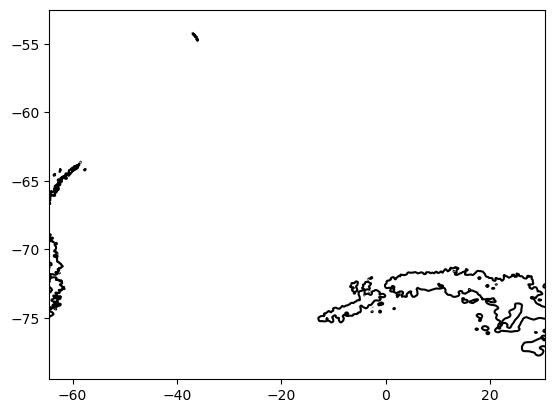

In [20]:
plt.contour(bath_wg.lon, bath_wg.lat, bath_wg, levels=[1000], colors='k')

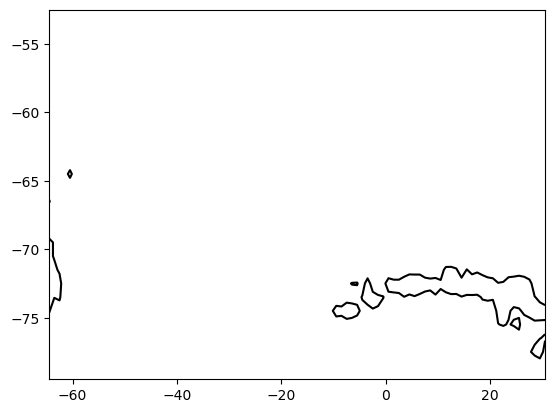

In [21]:
plt.contour(bath_wg_woa.lon, bath_wg_woa.lat, bath_wg_woa, levels=[1000], colors='k')

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


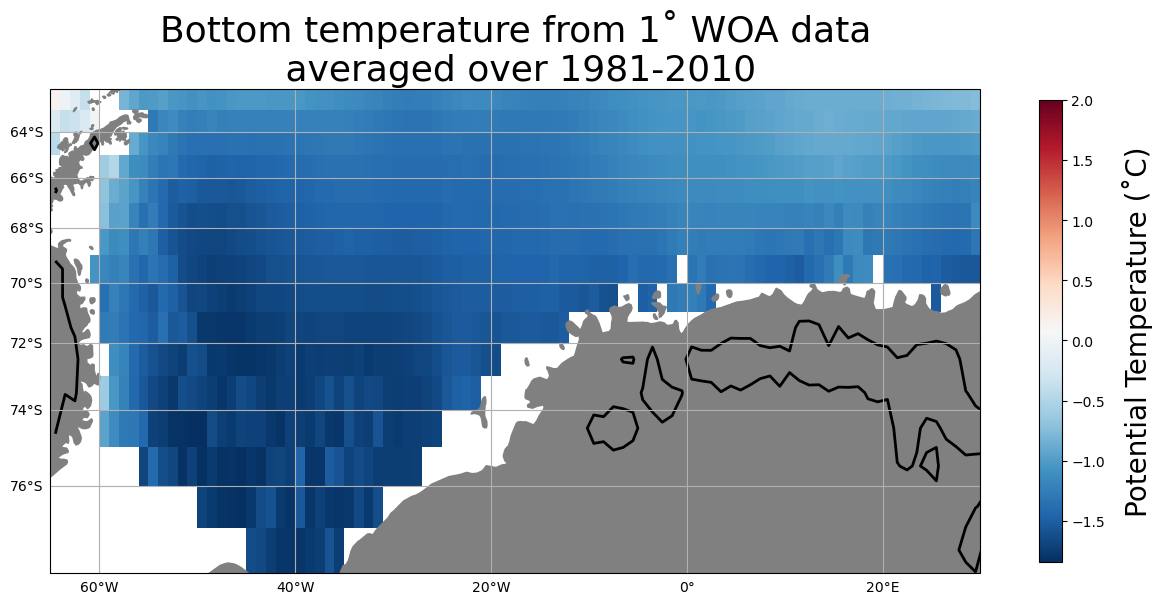

In [23]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

#1000m isobath
ax.contour(bath_wg_woa.lon, bath_wg_woa.lat, bath_wg_woa, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(pt_bottom_wg.lon, pt_bottom_wg.lat, pt_bottom_wg[0], transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature (˚C)", labelpad=12, fontsize=20)

#ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

plt.title('Bottom temperature from 1˚ WOA data\n averaged over 1981-2010', fontsize=26)
plt.savefig('bot-temp-woa8110-1kmisobath.pdf');

## <span style='color:Red'> Bottom Temperature Error (start)

In [24]:
pt_error = xr.apply_ufunc(gsw.pt0_from_t, sa, ds.tse, pressure,
                    output_dtypes=[ds.tse.dtype],
                    dask='parallelized').reset_coords(drop=True)
pt_error.name = 'PT_error'

## <span style='color:Brown'> Bottom Potential Temperature Error

In [25]:
# this gives us the depth of the bottom cell
lev_max_error = pt_error.lev.where(pt_error.notnull()).max(dim='lev')
# which we can use as an indexer
pt_bottom_error = pt_error.sel(lev=lev_max_error.fillna(0.))

In [26]:
pt_bottom_wg_error = pt_bottom_error.sel(**lat_range, **lon_range)

In [27]:
surface_mask_pt_error = (pt_bottom_wg_error.notnull()).load()

In [28]:
pt_bottom_wg_error.to_netcdf('pt_bottom_error.nc', mode='w')

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:150: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:584: CFWarning: this date/calendar/year zero convention is not supported by CF
  return np.nan if d is None else cftime.date2num(d, units, calendar)


/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


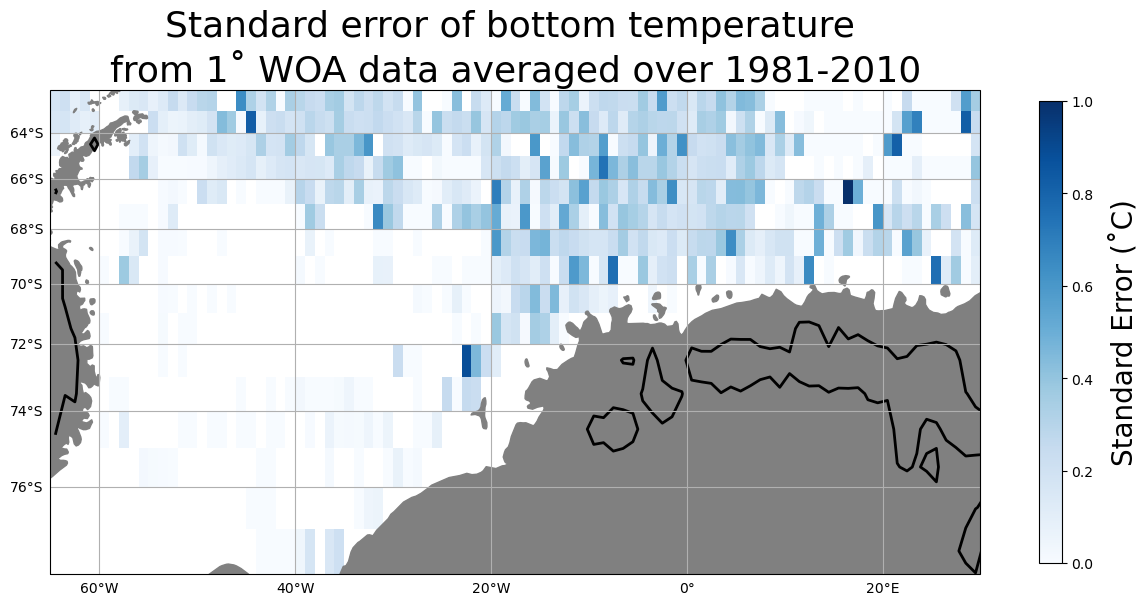

In [29]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
#1000m isobath
ax.contour(bath_wg_woa.lon, bath_wg_woa.lat, bath_wg_woa, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(pt_bottom_wg_error.lon, pt_bottom_wg_error.lat, pt_bottom_wg_error[0], transform=ccrs.PlateCarree(), cmap='Blues', vmax=1)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Standard Error (˚C)", labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

plt.title('Standard error of bottom temperature \nfrom 1˚ WOA data averaged over 1981-2010', fontsize=26)
plt.savefig('ste-bot-temp-woa8110-1kmisobath.pdf');

## <span style='color:Red'> Bottom Temperature Error (end)

## <span style='color:Brown'> Bottom Practical Salinities

In [30]:
# this gives us the depth of the bottom cell
lev_max_slt = ds.san.lev.where(ds.san.notnull()).max(dim='lev')
# which we can use as an indexer
san_bottom = ds.san.sel(lev=lev_max_slt.fillna(0.))

In [31]:
san_bottom_wg = san_bottom.sel(**lat_range, **lon_range)

In [32]:
surface_mask_san = (san_bottom_wg.notnull()).load()

In [33]:
san_bottom_wg

<xarray.DataArray 'san' (time: 1, lat: 28, lon: 96)>
array([[[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [34.155388, 34.323288, ..., 34.65721 , 34.65479 ],
        [33.99351 , 34.22631 , ..., 34.65731 , 34.65951 ]]], dtype=float32)
Coordinates:
  * time     (time) object -0001-01-15 00:00:00
    lev      (time, lat, lon) float64 0.0 0.0 0.0 ... 4.4e+03 4.9e+03 5.5e+03
  * lat      (lat) float64 -79.5 -78.5 -77.5 -76.5 ... -55.5 -54.5 -53.5 -52.5
  * lon      (lon) float64 -64.5 -63.5 -62.5 -61.5 -60.5 ... 27.5 28.5 29.5 30.5
Attributes:
    long_name:  objectively analyzed mean sea water salinity [1e-3]

In [34]:
san_bottom_wg.to_netcdf('san_bottom_wg_8110.nc')

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:150: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:584: CFWarning: this date/calendar/year zero convention is not supported by CF
  return np.nan if d is None else cftime.date2num(d, units, calendar)


/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


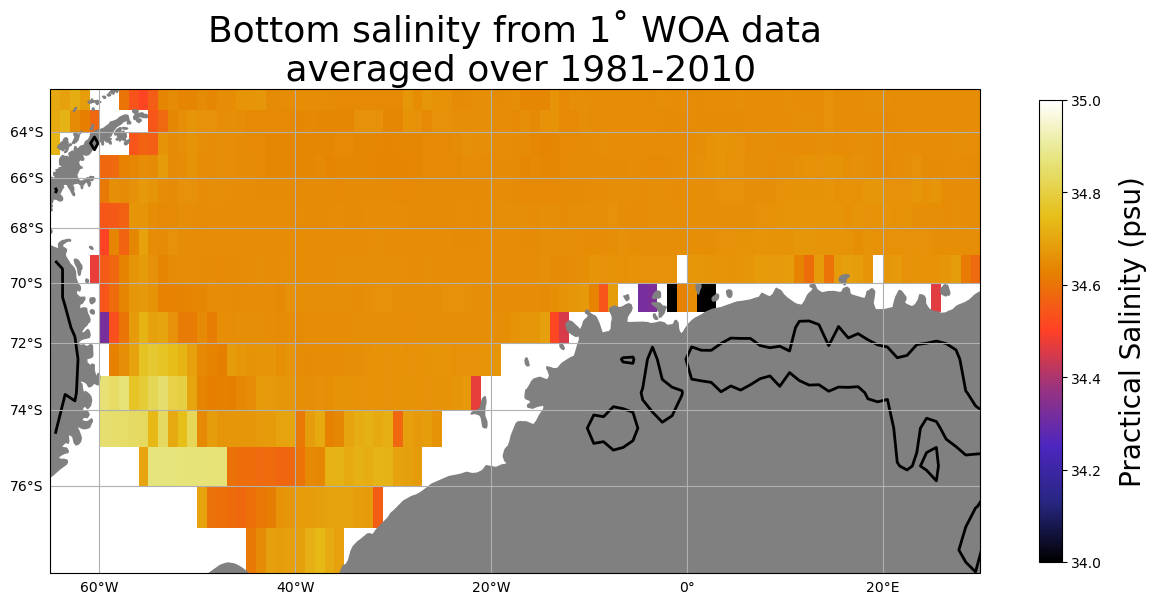

In [35]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))
#1000m isobath
ax.contour(bath_wg_woa.lon, bath_wg_woa.lat, bath_wg_woa, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(san_bottom_wg.lon, san_bottom_wg.lat, san_bottom_wg[0], cmap='CMRmap', vmin=34, vmax=35, transform=ccrs.PlateCarree())

cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label('Practical Salinity (psu)', labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

plt.title('Bottom salinity from 1˚ WOA data\n averaged over 1981-2010', fontsize=26 )
plt.savefig('bot-salt-woa8110-1kmisobath.pdf');

## <span style='color:Red'> Bottom Salinity Error (start)

In [36]:
# this gives us the depth of the bottom cell
lev_max_slt_error = ds.sse.lev.where(ds.sse.notnull()).max(dim='lev')
# which we can use as an indexer
san_bottom_error = ds.sse.sel(lev=lev_max_slt_error.fillna(0.))

In [37]:
san_bottom_wg_error = san_bottom_error.sel(**lat_range, **lon_range)

In [38]:
san_bottom_wg_error.to_netcdf('san_bottom_error.nc', mode='w')

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:150: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:584: CFWarning: this date/calendar/year zero convention is not supported by CF
  return np.nan if d is None else cftime.date2num(d, units, calendar)


In [39]:
surface_mask_san_error = (san_bottom_wg_error.notnull()).load()

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


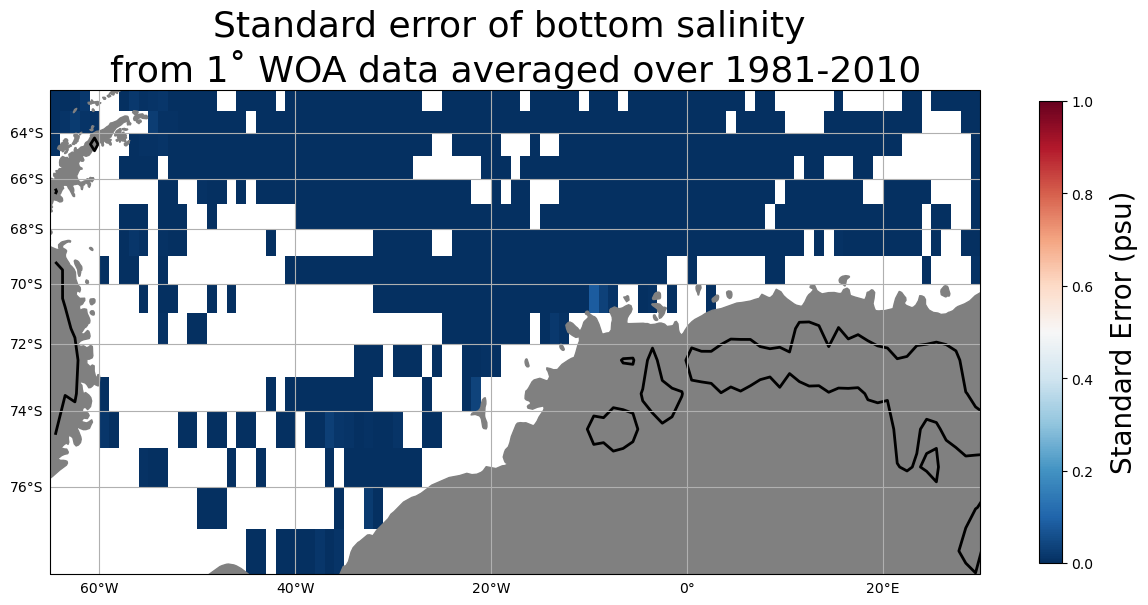

In [40]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))
#1000m isobath
ax.contour(bath_wg_woa.lon, bath_wg_woa.lat, bath_wg_woa, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(san_bottom_wg_error.lon, 
                   san_bottom_wg_error.lat, 
                   san_bottom_wg_error[0], cmap='RdBu_r', transform=ccrs.PlateCarree(), vmax=1)

cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label('Standard Error (psu)', labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

plt.title('Standard error of bottom salinity \nfrom 1˚ WOA data averaged over 1981-2010', fontsize=26 )
plt.savefig('ste-bot-salt-woa8110-1kmisobath.pdf');

## <span style='color:Red'> Bottom Salinity Error (end)

In [52]:
ds_salt_0517 = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA18/1_deg/annual/2005-2017/salt')
ds_temp_0517 = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA18/1_deg/annual/2005-2017/temp')
ds_0517 = xr.merge([ds_salt_0517, ds_temp_0517])
ds_0517

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:144: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:195: CFWarning: this date/calendar/year zero convention is not supported by CF
  cftime.num2date(num_dates, units, calendar, only_use_cftime_datetimes=True)
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use

<xarray.Dataset>
Dimensions:  (time: 1, lev: 102, lat: 180, lon: 360)
Coordinates:
  * time     (time) object -001-01-15 00:00:00
  * lev      (lev) float64 0.0 5.0 10.0 15.0 ... 5.2e+03 5.3e+03 5.4e+03 5.5e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables: (12/14)
    san      (time, lev, lat, lon) float32 ...
    smn      (time, lev, lat, lon) float32 ...
    sdd      (time, lev, lat, lon) float32 ...
    ssd      (time, lev, lat, lon) float32 ...
    sse      (time, lev, lat, lon) float32 ...
    soa      (time, lev, lat, lon) float32 ...
    ...       ...
    tmn      (time, lev, lat, lon) float32 ...
    tdd      (time, lev, lat, lon) float32 ...
    tsd      (time, lev, lat, lon) float32 ...
    tse      (time, lev, lat, lon) float32 ...
    toa      (time, lev, lat, lon) float32 ...
    tgp      (time, lev, lat, lon) float32 ...
Attributes:
    title:          World Ocean Atlas 2018: sea water salinity Annual 2005-20...
    Conventions:    COARDS\nGrADS
    dataType:       Grid
    documentation:  http://apdrc.soest.hawaii.edu/datadoc/woa18.php
    history:        Fri Jan 28 10:58:46 HST 2022 : imported by GrADS Data Ser...

## <span style='color:Brown'> Converting __in situ__ temperature to __potential__ temperature

In [53]:
tan_0517 = ds_0517.tan.load()

In [54]:
#change levels to pressure
pressure_0517 = xr.apply_ufunc(gsw.p_from_z, tan_0517.lev, tan_0517.lat, 
                          output_dtypes=[float, ],
                          dask='parallelized').reset_coords(drop=True).load()
pressure_0517.name = 'pressure'

In [55]:
#change practical salinity [psu] to absolute salinity [g/kg]
sa_0517 = xr.apply_ufunc(gsw.SA_from_SP, ds_0517.san, pressure_0517, ds_0517.lon, ds_0517.lat,
                    output_dtypes=[ds_0517.san.dtype],
                    dask='parallelized').reset_coords(drop=True)
sa_0517.name = 'SA'

In [56]:
pt_0517 = xr.apply_ufunc(gsw.pt0_from_t, sa_0517, tan_0517, pressure_0517,
                    output_dtypes=[tan_0517.dtype],
                    dask='parallelized').reset_coords(drop=True)
pt_0517.name = 'PT'

## <span style='color:Brown'> Bottom Potential Temperatures

In [57]:
# this gives us the depth of the bottom cell
lev_max_0517 = pt_0517.lev.where(pt_0517.notnull()).max(dim='lev')
# which we can use as an indexer
pt_bottom_0517 = pt_0517.sel(lev=lev_max_0517.fillna(0.))

In [58]:
pt_bottom_wg_0517 = pt_bottom_0517.sel(**lat_range, **lon_range)

In [59]:
surface_mask_pt_0517 = (pt_bottom_wg_0517.notnull()).load()

In [60]:
pt_bottom_wg_0517 = xr.open_dataset('/home/jovyan/WMT-project/WOA/pt_bottom_wg_0517.nc')
pt_bottom_wg_0517

<xarray.Dataset>
Dimensions:  (time: 1, lat: 19, lon: 96)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
    lev      (time, lat, lon) float64 ...
  * lat      (lat) float64 -79.5 -78.5 -77.5 -76.5 ... -64.5 -63.5 -62.5 -61.5
  * lon      (lon) float64 -64.5 -63.5 -62.5 -61.5 -60.5 ... 27.5 28.5 29.5 30.5
Data variables:
    PT       (time, lat, lon) float64 ...

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


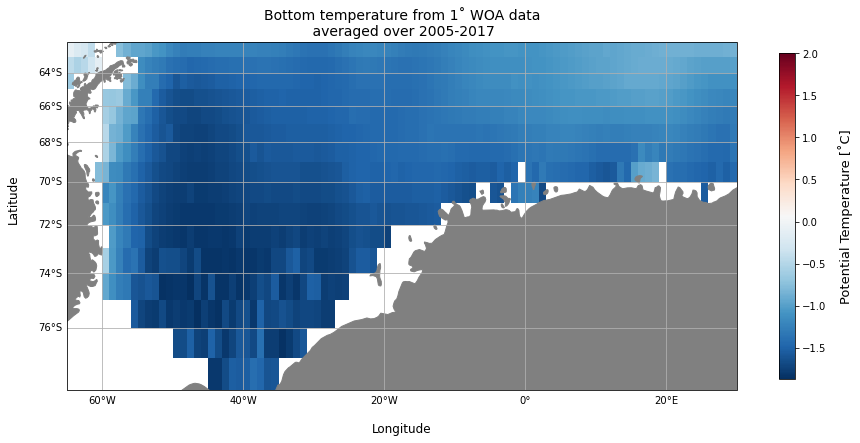

In [61]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))

im = ax.pcolormesh(pt_bottom_wg_0517.lon, pt_bottom_wg_0517.lat, pt_bottom_wg_0517.PT[0], transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=2)

cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label('Potential Temperature [˚C]', labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Bottom temperature from 1˚ WOA data\n averaged over 2005-2017', fontsize=14);

## <span style='color:Red'> Bottom Temperature Error (start)

In [57]:
ds_0517.tse

<xarray.DataArray 'tse' (time: 1, lev: 102, lat: 180, lon: 360)>
[6609600 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
  * lev      (lev) float64 0.0 5.0 10.0 15.0 ... 5.2e+03 5.3e+03 5.4e+03 5.5e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Attributes:
    long_name:  standard error about the statistical mean sea water temperatu...

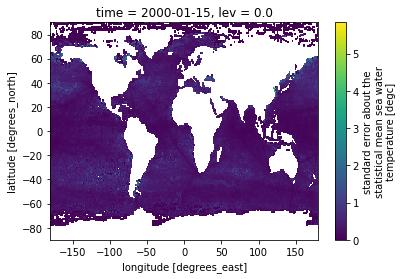

In [58]:
ds_0517.tse[0,0].plot()

In [62]:
pt_0517_error = xr.apply_ufunc(gsw.pt0_from_t, sa_0517, ds_0517.tse, pressure_0517,
                    output_dtypes=[tan_0517.dtype],
                    dask='parallelized').reset_coords(drop=True)
pt_0517_error.name = 'PT_error'

In [63]:
# this gives us the depth of the bottom cell
lev_max_0517_error = pt_0517_error.lev.where(pt_0517_error.notnull()).max(dim='lev')
# which we can use as an indexer
pt_bottom_0517_error = pt_0517_error.sel(lev=lev_max_0517_error.fillna(0.))

In [64]:
pt_bottom_wg_0517_error = pt_bottom_0517_error.sel(**lat_range, **lon_range)

In [65]:
pt_bottom_wg_0517_error.to_netcdf('pt_bottom_0517_error.nc', mode='w')

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:144: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:570: CFWarning: this date/calendar/year zero convention is not supported by CF
  return np.nan if d is None else cftime.date2num(d, units, calendar)


In [66]:
surface_mask_pt_0517_error = (pt_bottom_wg_0517_error.notnull()).load()

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


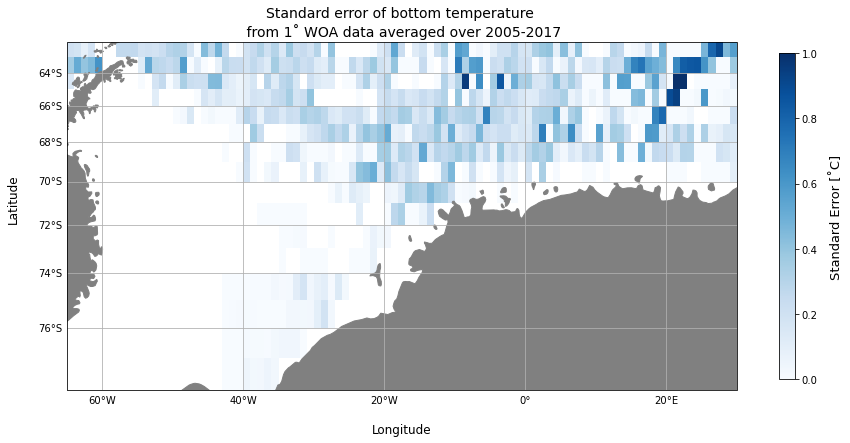

In [67]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))

im = ax.pcolormesh(pt_bottom_wg_0517_error.lon, 
                   pt_bottom_wg_0517_error.lat, 
                   pt_bottom_wg_0517_error[0], cmap='Blues', transform=ccrs.PlateCarree(), vmax=1)

cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label('Standard Error [˚C]', labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Standard error of bottom temperature \n from 1˚ WOA data averaged over 2005-2017', fontsize=14);

## <span style='color:Red'> Bottom Temperature Error (end)

## <span style='color:Red'> Bottom Temperature Standard Deviation (start)

In [68]:
pt_0517_std = xr.apply_ufunc(gsw.pt0_from_t, sa_0517, ds_0517.tsd, pressure_0517,
                    output_dtypes=[ds_0517.tsd.dtype],
                    dask='parallelized').reset_coords(drop=True)
pt_0517_std.name = 'PT_std'

In [69]:
pt_0517_std

<xarray.DataArray 'PT_std' (time: 1, lev: 102, lat: 180, lon: 360)>
array([[[[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [0.        ,        nan,        nan, ...,        nan,
          0.        , 0.00164387],
         [0.        , 0.        ,        nan, ...,        nan,
          0.07499999,        nan],
         [       nan, 0.        ,        nan, ...,        nan,
                 nan,        nan]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
...
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]]]])
Coordinates:
  * time     (time) object -001-01-15 00:00:00
  * lev      (lev) float64 0.0 5.0 10.0 15.0 ... 5.2e+03 5.3e+03 5.4e+03 5.5e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

In [70]:
# this gives us the depth of the bottom cell
lev_max_0517_std = pt_0517_std.lev.where(pt_0517_std.notnull()).max(dim='lev')
# which we can use as an indexer
pt_bottom_0517_std = pt_0517_std.sel(lev=lev_max_0517_std.fillna(0.))

In [71]:
pt_bottom_wg_0517_std = pt_bottom_0517_std.sel(**lat_range, **lon_range)

In [72]:
surface_mask_pt_0517_std = (pt_bottom_wg_0517_std.notnull()).load()

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


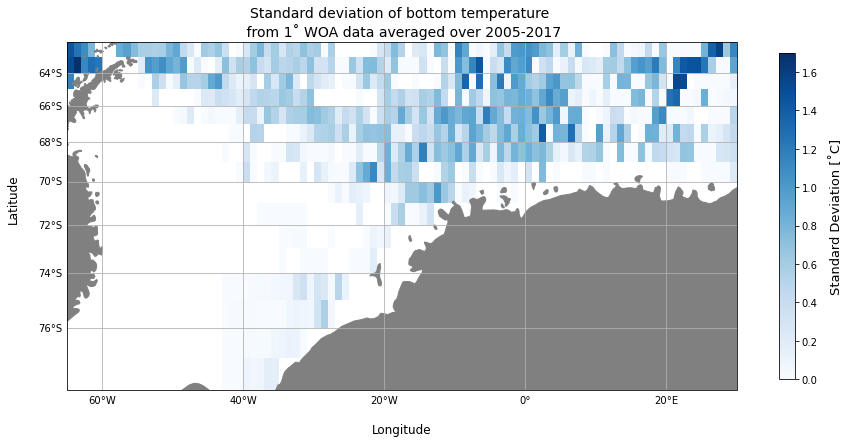

In [73]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))

im = ax.pcolormesh(pt_bottom_wg_0517_std.lon, 
                   pt_bottom_wg_0517_std.lat, 
                   pt_bottom_wg_0517_std[0], cmap='Blues', transform=ccrs.PlateCarree())#,vmax=2)

cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label('Standard Deviation [˚C]', labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Standard deviation of bottom temperature \n from 1˚ WOA data averaged over 2005-2017', fontsize=14);

## <span style='color:Red'> Bottom Temperature Standard Deviation (end)

In [74]:
# this gives us the depth of the bottom cell
lev_max_slt_0517 = ds_0517.san.lev.where(ds_0517.san.notnull()).max(dim='lev')
# which we can use as an indexer
san_bottom_0517 = ds_0517.san.sel(lev=lev_max_slt_0517.fillna(0.))

In [75]:
san_bottom_wg_0517 = san_bottom_0517.sel(**lat_range, **lon_range)

In [76]:
surface_mask_san_0517 = (san_bottom_wg_0517.notnull()).load()

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


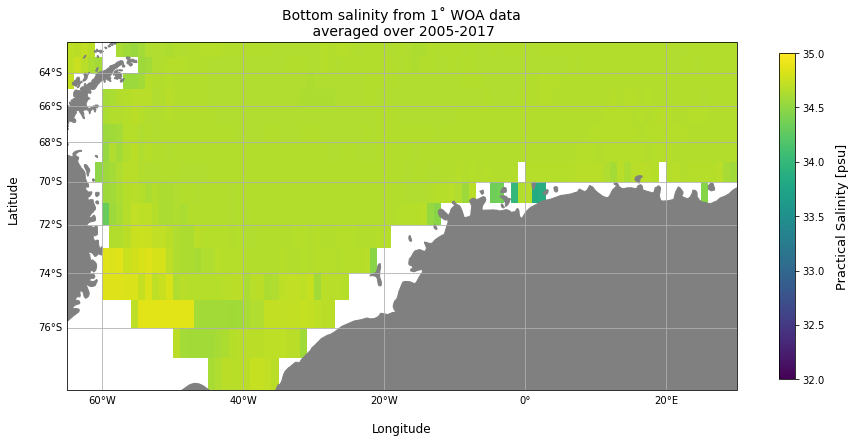

In [77]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))

im = ax.pcolormesh(san_bottom_wg_0517.lon, 
                   san_bottom_wg_0517.lat, 
                   san_bottom_wg_0517[0], cmap='viridis', vmin=32, vmax=35, transform=ccrs.PlateCarree())

cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label('Practical Salinity [psu]', labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Bottom salinity from 1˚ WOA data\n averaged over 2005-2017', fontsize=14, );

## <span style='color:Red'> Bottom Salinity Error (start)

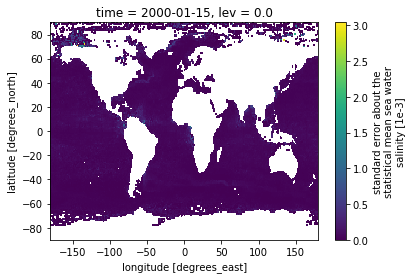

In [74]:
ds_0517.sse[0,0].plot()

In [78]:
# this gives us the depth of the bottom cell
lev_max_slt_0517_error = ds_0517.sse.lev.where(ds_0517.sse.notnull()).max(dim='lev')
# which we can use as an indexer
san_bottom_0517_error = ds_0517.sse.sel(lev=lev_max_slt_0517_error.fillna(0.))

In [79]:
san_bottom_wg_0517_error = san_bottom_0517_error.sel(**lat_range, **lon_range)

In [80]:
san_bottom_wg_0517_error.to_netcdf('san_bottom_wg_0517_error.nc')

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:144: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:570: CFWarning: this date/calendar/year zero convention is not supported by CF
  return np.nan if d is None else cftime.date2num(d, units, calendar)


In [81]:
surface_mask_san_0517_error = (san_bottom_wg_0517_error.notnull()).load()

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


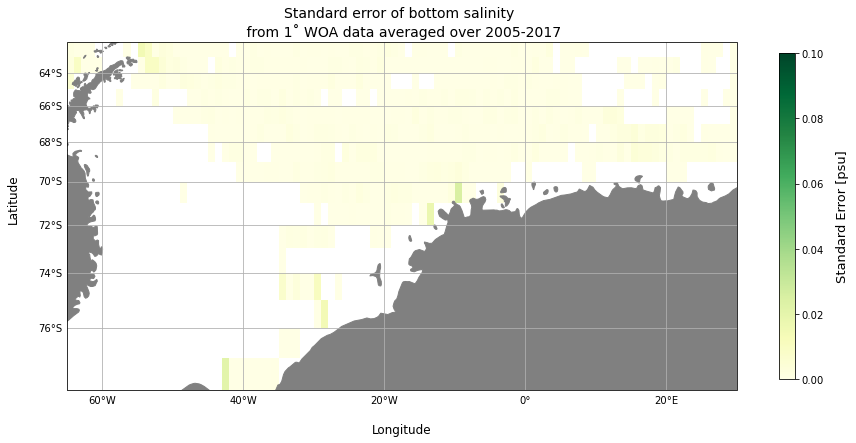

In [82]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))

im = ax.pcolormesh(san_bottom_wg_0517_error.lon, 
                   san_bottom_wg_0517_error.lat, 
                   san_bottom_wg_0517_error[0], cmap='YlGn', transform=ccrs.PlateCarree(), vmax=0.1)

cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label('Standard Error [psu]', labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Standard error of bottom salinity \n from 1˚ WOA data averaged over 2005-2017', fontsize=14, );

## <span style='color:Red'> Bottom Salinity Error (end)

## <span style='color:Red'> Bottom Salinity Standard Deviation (start)

In [83]:
# this gives us the depth of the bottom cell
lev_max_slt_0517_std = ds_0517.ssd.lev.where(ds_0517.ssd.notnull()).max(dim='lev')
# which we can use as an indexer
san_bottom_0517_std = ds_0517.ssd.sel(lev=lev_max_slt_0517_std.fillna(0.))

In [84]:
san_bottom_wg_0517_std = san_bottom_0517_std.sel(**lat_range, **lon_range)

In [85]:
surface_mask_san_0517_std = (san_bottom_wg_0517_std.notnull()).load()

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


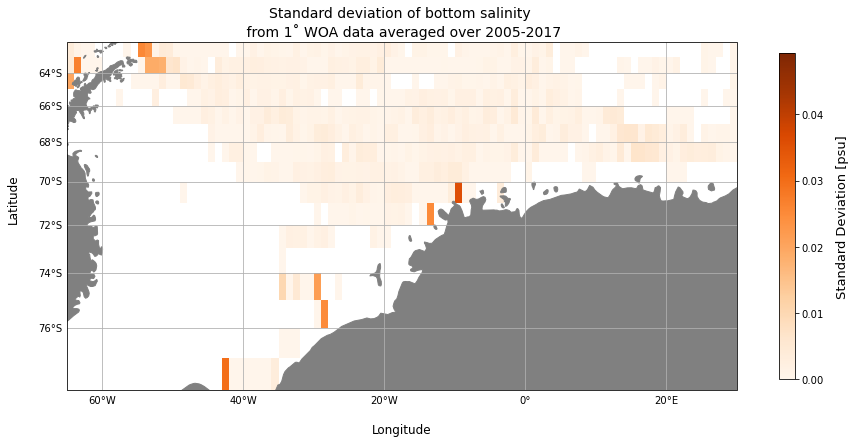

In [86]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))

im = ax.pcolormesh(san_bottom_wg_0517_std.lon, 
                   san_bottom_wg_0517_std.lat, 
                   san_bottom_wg_0517_std[0], cmap='Oranges', transform=ccrs.PlateCarree())

cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label('Standard Deviation [psu]', labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Standard deviation of bottom salinity \n from 1˚ WOA data averaged over 2005-2017', fontsize=14, );

## <span style='color:Red'> Bottom Temperature Standard Deviation (end)

# <span style='color:Gold'> THE END